In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from sklearn import linear_model
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (11,6)
legend_fontsize = 16

# from matplotlib import rc
# rc('font',**{'family':'sans-serif'})
# rc('text', usetex=True)
# rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
# rc('text.latex',preamble=r'\usepackage[russian]{babel}')
# rc('figure', **{'dpi': 300})

# Байесовский вывод для испытаний Бернулли

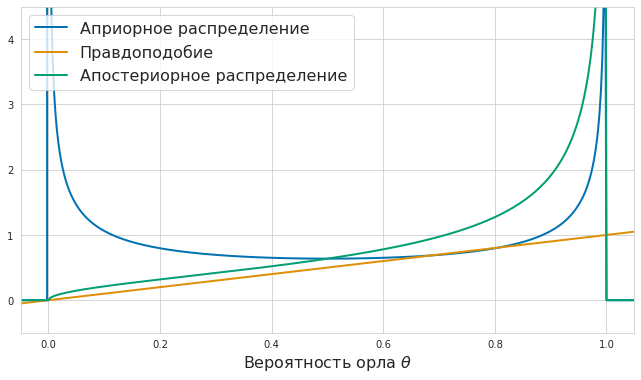

In [3]:
xs = np.arange(-0.5, 1.5, 0.0025)

prior_params = (.5, .5)
experimental_data = (1, 0)

## Априорное распределение
pri = st.beta(prior_params[0], prior_params[1]).pdf
norm_prior = 1 #integrate.quad(lambda x: pri(x), -np.inf, np.inf)[0]
ys_prior = [ pri(x) / norm_prior for x in xs ]

## Правдоподобие
n_heads, n_tails = experimental_data
lk = lambda x : x ** n_heads * (1 - x) ** n_tails
ys_like = [ lk(x) for x in xs ]

## Апостериорное распределение
post = lambda x : lk(x) * pri(x)
norm_post = integrate.quad(lambda x: post(x), 0, 1)[0]
ys_post = [ post(x) / norm_post if x > 0 and x < 1 else 0 for x in xs ]

## И нарисуем
fig, ax = plt.subplots(figsize=figsize)
ax.plot(xs, ys_prior, linewidth=2, label=r"Априорное распределение")
ax.plot(xs, ys_like, linewidth=2, label=r"Правдоподобие")
ax.plot(xs, ys_post, linewidth=2, label=r"Апостериорное распределение")
ax.set_xlim((-0.05, 1.05))
ax.set_ylim((-0.5, 4.5))
ax.set_xlabel(r"Вероятность орла $\theta$", fontsize=legend_fontsize)
ax.legend(loc="upper left", fontsize=legend_fontsize)
plt.show()

# Линейная и полиномиальная регрессия

In [4]:
## Оверфиттинг
## Исходная функция
orig = lambda x : np.sin(2*x)

## X-координаты точек данных
xd = np.array([-3, -2, -1, -0.5, 0, 0.5, 1, 1.5, 2.5, 3, 4]) / 2
num_points = len(xd)

## Данные
data = orig(xd) + np.random.normal(0, .25, num_points)

## X-координаты точек данных
xd_large = np.arange(-1.5, 2, 0.05)
num_points_l = len(xd_large)

## Данные
data_large = orig(xd_large) + np.random.normal(0, .25, num_points_l)


## Для рисования
xs = np.arange(xd[0]-1.5, xd[-1]+1.5, 0.01)

[ 1.76046729  0.25486566 -0.69921151]
[  0.27746661  -8.1262784   20.24911757  37.92290371 -79.96999201
 -24.94571124  83.49162107 -13.0102862  -23.09774414   7.70252206]


(-2.0, 2.5)

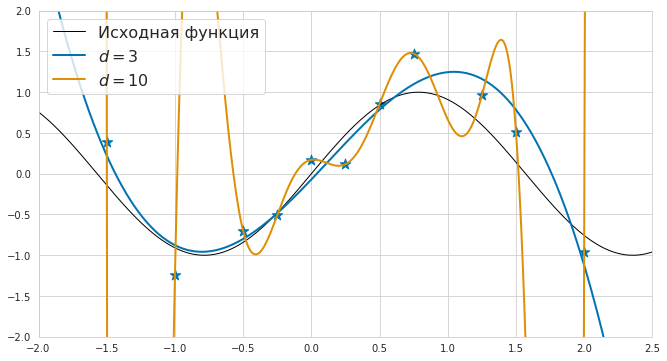

In [5]:
## Выделение полиномиальных признаков
xs_d = np.vstack([xs ** i for i in range(1, num_points+1)]).transpose()
xd_d = np.vstack([xd ** i for i in range(1, num_points+1)]).transpose()

## Какие степени многочлена будем обучать и рисовать
set_of_powers = [ 3, 10]

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
ax.set_ylim((-2, 2))
ax.scatter(xd, data, marker='*', s=120)
ax.plot(xs, orig(xs), linewidth=1, label="Исходная функция", color="black")

for d in set_of_powers:
    if d == 0:
        print(np.mean(data))
        ax.hlines(np.mean(data), xmin=xs[0], xmax=xs[-1], label="$d=0$", linestyle="dashed")
    else:
        cur_model = linear_model.LinearRegression(fit_intercept=True).fit( xd_d[:, :d], data )
        print(cur_model.coef_)
        ax.plot(xs, cur_model.predict( xs_d[:, :d] ), linewidth=2, label="$d=%d$" % d)

ax.legend(loc="upper left", fontsize=legend_fontsize)
ax.set_xlim((-2, 2.5))
# plt.show()

## Локальные признаки в линейной регрессии

Коэффициенты с 5 признаками: -12.4235 -12.3435 -11.1659 -9.6164 -13.8650


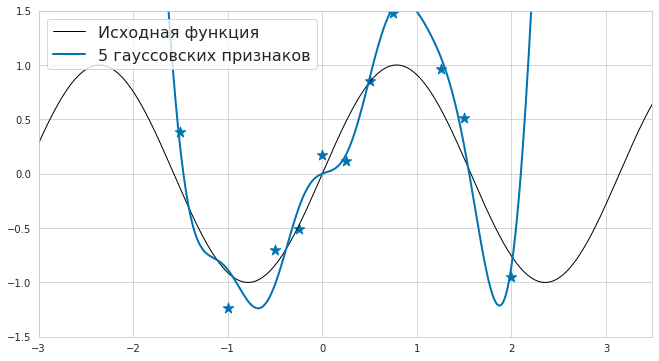

In [6]:
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

nums_gauss = [5 ]
gauss_xd, gauss_yd = xd, data

class GaussianFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, N, width_factor=.5):
        self.N = N
        self.width_factor = width_factor
    
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
        
    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
        
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_, self.width_, axis=1)

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
ax.set_ylim((-1.5, 1.5))
ax.scatter(gauss_xd, gauss_yd, marker='*', s=120)
ax.plot(xs, orig(xs), linewidth=1, label="Исходная функция", color="black")

for num_gauss in nums_gauss:
    gauss_model = make_pipeline(GaussianFeatures(num_gauss),
                                linear_model.LinearRegression())
    gauss_model.fit(xd[:, np.newaxis], data)
    yfit = gauss_model.predict(xs[:, np.newaxis])
    print("Коэффициенты с %d признаками: %s" % (num_gauss, " ".join(["%.4f" % x for x in gauss_model.get_params()['linearregression'].coef_])))
    ax.plot(xs, yfit, linewidth=2, label="%d гауссовских признак%s" % (num_gauss, "а" if num_gauss < 5 else "ов") )

ax.legend(loc="upper left", fontsize=legend_fontsize)

plt.show()

In [7]:
num_gauss = 5
gauss_model = make_pipeline(GaussianFeatures(num_gauss), linear_model.LinearRegression())
gauss_model.fit(gauss_xd[:, np.newaxis], gauss_yd)
yfit = gauss_model.predict(xs[:, np.newaxis])
mfeat = gauss_model.get_params()['gaussianfeatures']
mregr = gauss_model.get_params()['linearregression']
print("Коэффициенты с %d признаками: %s" % (num_gauss, " ".join(["%.4f" % x for x in gauss_model.get_params()['linearregression'].coef_])))
print("Свободный член: %.4f" % mregr.intercept_)

Коэффициенты с 5 признаками: -12.4235 -12.3435 -11.1659 -9.6164 -13.8650
Свободный член: 14.3213


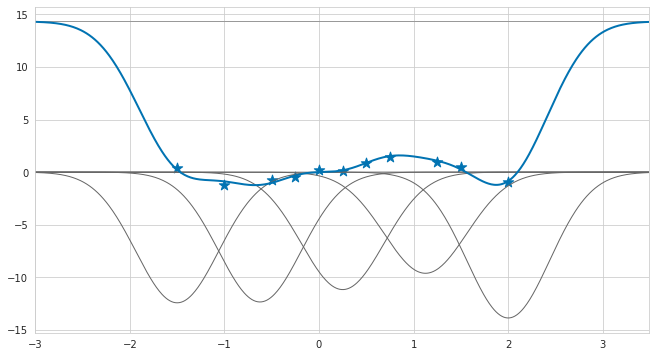

In [8]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
# ax.set_ylim((-1.5, 1.5))
ax.scatter(gauss_xd, gauss_yd, marker='*', s=120)
# ax.plot(xs, orig(xs), linewidth=1, label="Исходная функция", color="black")

for i in range(mfeat.N):
    cur_yfit = [mregr.coef_[i] * mfeat._gauss_basis(x, mfeat.centers_[i], mfeat.width_) for x in xs]
    ax.plot(xs, cur_yfit, color="0.4", linewidth=1)
    ax.plot(xs, [mregr.intercept_ for _ in range(len(xs))], color="0.6", linewidth=1)

ax.plot(xs, yfit, linewidth=2)

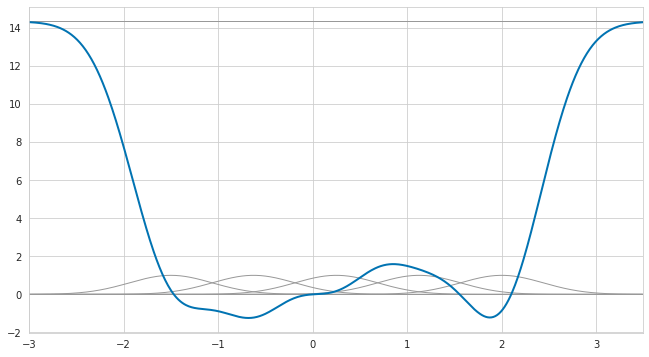

In [9]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))

for i in range(mfeat.N):
    cur_yfit = [mfeat._gauss_basis(x, mfeat.centers_[i], mfeat.width_) for x in xs]
    ax.plot(xs, cur_yfit, color="0.6", linewidth=1)
    ax.plot(xs, [mregr.intercept_ for _ in range(len(xs))], color="0.6", linewidth=1)

ax.plot(xs, yfit, linewidth=2)

## Добавим ещё данных

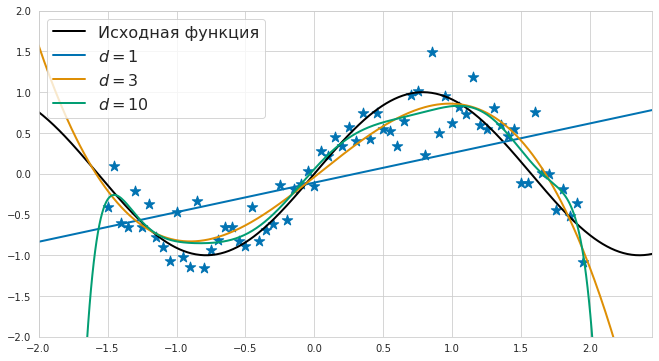

In [10]:
## Исходная функция
orig = lambda x : np.sin(2*x)

## Для 
xs = np.arange(xd_large[0]-.5, xd_large[-1]+.5, 0.01)

## Выделение полиномиальных признаков
xs_d = np.vstack([xs ** i for i in range(1, num_points+1)]).transpose()
xd_d_large = np.vstack([xd_large ** i for i in range(1, num_points+1)]).transpose()

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
ax.set_ylim((-2, 2))
ax.scatter(xd_large, data_large, marker='*', s=120)
ax.plot(xs, orig(xs), linewidth=2, label="Исходная функция", color="black")

set_of_powers = [ 1, 3, 10 ]

for d in set_of_powers:
    cur_model = linear_model.LinearRegression(fit_intercept=True).fit( xd_d_large[:, :d], data_large )
    ax.plot(xs, cur_model.predict( xs_d[:, :d] ), linewidth=2, label="$d=%d$" % d)

ax.legend(loc="upper left", fontsize=legend_fontsize)

plt.show()

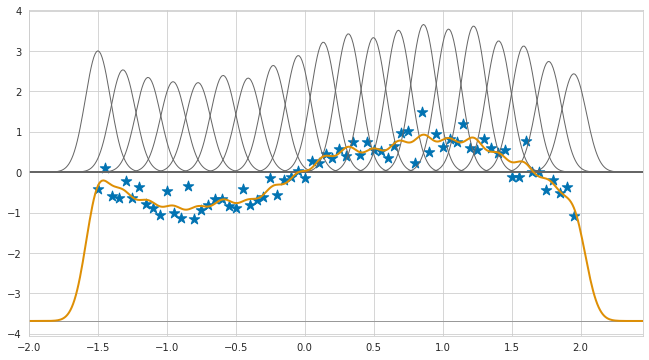

In [11]:
num_gauss=20

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
# ax.set_ylim((-1.5, 1.5))
ax.scatter(xd_large, data_large, marker='*', s=120)
# ax.plot(xs, orig(xs), linewidth=1, label="Исходная функция", color="black")

gauss_model = make_pipeline(GaussianFeatures(num_gauss), linear_model.LinearRegression())
gauss_model.fit(xd_large[:, np.newaxis], data_large)
yfit = gauss_model.predict(xs[:, np.newaxis])
mfeat = gauss_model.get_params()['gaussianfeatures']
mregr = gauss_model.get_params()['linearregression']

for i in range(mfeat.N):
    cur_yfit = [mregr.coef_[i] * mfeat._gauss_basis(x, mfeat.centers_[i], mfeat.width_) for x in xs]
    ax.plot(xs, cur_yfit, color="0.4", linewidth=1)
    ax.plot(xs, [mregr.intercept_ for _ in range(len(xs))], color="0.6", linewidth=1)

ax.plot(xs, yfit, color="C1", linewidth=2)

## Регуляризация

Коэффициенты для alpha=0.000000:
[  0.27746661  -8.1262784   20.24911757  37.92290371 -79.96999201
 -24.94571124  83.49162107 -13.0102862  -23.09774414   7.70252206]
Коэффициенты для alpha=0.010000:
[ 1.54172986e+00  0.00000000e+00 -0.00000000e+00 -7.96475679e-02
 -2.83574346e-01  2.74948653e-02 -7.27372973e-04  1.37314289e-02
 -2.53731333e-03  2.33156371e-03]
Коэффициенты для alpha=1.000000:
[ 0.          0.          0.          0.          0.          0.
  0.          0.         -0.00063562 -0.00076942]


/home/mis-knaumenko/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.497e-02, tolerance: 7.366e-04
  model = cd_fast.enet_coordinate_descent(


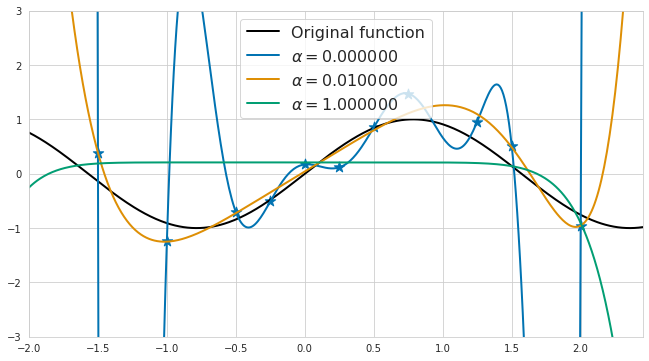

In [12]:
alpha_values = [ 0, .01, 1]
use_lasso = True


def train_model(xs, ys, alpha, use_lasso):
    if alpha == 0:
        return linear_model.LinearRegression(fit_intercept=True).fit( xs, ys )
    else:
        if use_lasso:
            return linear_model.Lasso(alpha=alpha, fit_intercept=True).fit( xs, ys )
        else:
            return linear_model.Ridge(alpha=alpha, fit_intercept=True).fit( xs, ys )

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
ax.set_ylim((-3, 3))
ax.scatter(xd, data, marker='*', s=120)
ax.plot(xs, orig(xs), linewidth=2, label="Original function", color="black")

for alpha in alpha_values:
    m = train_model(xd_d[:, :10], data, alpha, use_lasso)
    print ("Коэффициенты для alpha=%f:\n%s" % (alpha, m.coef_))
    ax.plot(xs, m.predict( xs_d[:, :10] ), linewidth=2, label=r"$\alpha=%f$" % alpha)

ax.legend(loc="upper center", fontsize=legend_fontsize)
plt.show()